# Graph Generation

In [6]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import matplotlib.pyplot as plt

datapath = './data/'

In [2]:
with (open(datapath + 'stations_dict.pickle', "rb")) as openfile:
    stations_dict = pickle.load(openfile)

## Distance Graph

In [3]:
with (open(datapath + 'station_distance.pickle', "rb")) as openfile:
    station_distance_dict = pickle.load(openfile)

In [35]:
shape = (len(stations_dict), len(stations_dict))
distance_graph = np.zeros(shape)

distance_list = []

for start_id in station_distance_dict:
    for end_id in station_distance_dict[start_id]:
        if start_id != end_id:
            
            # index is the id mapped into array index with stations_dict
            start_index = stations_dict[start_id]['index']
            end_index = stations_dict[end_id]['index']
            
            # weight = distance^−1
            if station_distance_dict[start_id][end_id] == 0:
                print(start_id, end_id)
                break
            distance_graph[start_index, end_index] = 1 / station_distance_dict[start_id][end_id]
            
            # for the ECDF calcuations
            distance_list.append(station_distance_dict[start_id][end_id])

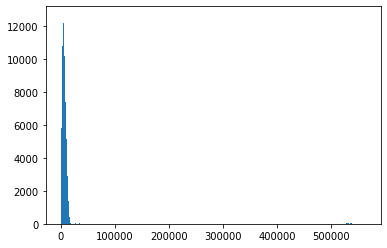

In [38]:
plt.hist(distance_list, bins=5000)
plt.show()

In [5]:
# generate the adjacency matrix for the graph
distance_adj = np.array(list(map(lambda x: 1 if x > 0 else 0, distance_graph.flatten()))).reshape(shape)

## Interaction Graph

In [39]:
with (open(datapath + 'ride_count.pickle', "rb")) as openfile:
    ride_count_dict = pickle.load(openfile)

In [40]:
shape = (len(stations_dict), len(stations_dict))
interaction_graph = np.zeros(shape)

interaction_list = []

for start_id in ride_count_dict:
    for end_id in ride_count_dict[start_id]:

        start_index = stations_dict[start_id]['index']
        end_index = stations_dict[end_id]['index']
        
        interaction_graph[start_index, end_index] = ride_count_dict[start_id][end_id]
        
        interaction_list.append(ride_count_dict[start_id][end_id])

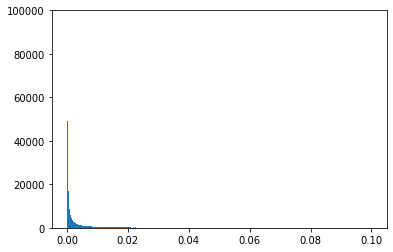

In [48]:
plt.hist(interaction_list, bins=1000, range=(0, 0.1))
plt.ylim((0, 100000))
plt.show()

In [8]:
# generate the adjacency matrix for the graph
interaction_adj = np.array(list(map(lambda x: 1 if x > 0 else 0, interaction_graph.flatten()))).reshape(shape)

# remove self loops?
for i in range(interaction_adj.shape[0]):
    interaction_adj[i][i] = 0

## Correlation Graph

In [9]:
with (open(datapath + 'in_hist.pickle', "rb")) as openfile:
    inflow_hist_dict = pickle.load(openfile)
    
with (open(datapath + 'out_hist.pickle', "rb")) as openfile:
    outflow_hist_dict = pickle.load(openfile)

In [10]:
from scipy.stats import pearsonr

inflow_correlation_graph = np.zeros(shape)
outflow_correlation_graph = np.zeros(shape)

# inflow correlation
for id_x in inflow_hist_dict:
    
    flow_x = np.zeros((24,))
    for i in range(24):
        if i in inflow_hist_dict[id_x]:
            flow_x[i] = inflow_hist_dict[id_x][i]
    
    for id_y in inflow_hist_dict:    
        if id_x != id_y:
            start_index = stations_dict[id_x]['index']
            end_index = stations_dict[id_y]['index']
            
            
            flow_y = np.zeros((24,))
            for i in range(24):
                if i in inflow_hist_dict[id_y]:
                    flow_y[i] = inflow_hist_dict[id_y][i]
                    
            
            inflow_correlation_graph[start_index][end_index] = pearsonr(flow_x, flow_y)[0]
            
# outflow correlation
for id_x in outflow_hist_dict:
    
    flow_x = np.zeros((24,))
    for i in range(24):
        if i in outflow_hist_dict[id_x]:
            flow_x[i] = outflow_hist_dict[id_x][i]
    
    for id_y in outflow_hist_dict:    
        if id_x != id_y:
            start_index = stations_dict[id_x]['index']
            end_index = stations_dict[id_y]['index']
            
            flox_y = np.zeros((24,))
            for i in range(24):
                if i in outflow_hist_dict[id_x]:
                    flow_x[i] = outflow_hist_dict[id_x][i]
                    
                if i in outflow_hist_dict[id_y]:
                    flow_y[i] = outflow_hist_dict[id_y][i]
                    
            
            outflow_correlation_graph[start_index][end_index] = pearsonr(flow_x, flow_y)[0]

In [11]:
# generate the adjacency matrix for the graphs
inflow_correlation_adj = np.array(list(map(lambda x: 1 if x > 0 else 0, inflow_correlation_graph.flatten()))).reshape(shape)
outflow_correlation_adj = np.array(list(map(lambda x: 1 if x > 0 else 0, outflow_correlation_graph.flatten()))).reshape(shape)

## Graph Fusion

In [12]:
from numpy.linalg import pinv
from scipy.special import softmax
from sklearn import preprocessing

# normalize the adjacency matrix: A′ = D^−1*A + I
def normalize_adj(adj):
    # calculate D
    D = np.zeros(adj.shape)
    for i in range(0, adj.shape[0]):
        D[i][i] = adj[i].sum()
        
    # A′ = D^−1*A + I
    a_norm = np.matmul(pinv(D), adj) + np.identity(adj.shape[0])
    
    return a_norm

def graph_fusion(adjacency_list, weight_list):
    """
    Performs graph fusion on list of graphs
    (Note: the adjacency_list and weight_list must be in same order)
    
    Args:
        adjacency_list (list): list of adjacency matrix as numpy arrays
        weight_list (list): list of weight matrix as numpy arrays
    """
    
    shape = adjacency_list[0].shape
    
    # first we must normalize each weight matrix
    # for now we are using scikit-learn normalization (normalizing over the whole matrix)
    # potential alternatives are: row-wise normalization
    weight_list_norm = []
    for mat in weight_list:
        weight_list_norm.append(preprocessing.normalize(mat))
    
    # element-wise softmax of weight matrices
    weight_mtrx = np.stack(weight_list_norm) # shape [# of graph, # graph node, # graph node]
    weight_mtrx_sftmx = np.array(weight_mtrx, dtype='float32') 
    for i in range(shape[0]):
        for j in range(shape[1]):
            weight_mtrx_sftmx[:, i, j] = softmax(weight_mtrx[:, i, j])
                    
    # normalize adjacency matrices
    norm_adj_list = []
    for adj in adjacency_list:
        norm_adj_list.append(normalize_adj(adj)) 
    norm_adjacency = np.stack(norm_adj_list) # shape [# of graph, # graph node, # graph node]
    
    F = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            F[i][j] = np.multiply(weight_mtrx_sftmx[:,i ,j], norm_adjacency[:,i ,j]).sum()
            
    return F

In [13]:
%%time
# here we are using both the inflow and outflow graph
## TODO: seperate usage?

# distance-iteraction-correlation(inflow)
adj_list = [distance_adj, interaction_adj, inflow_correlation_adj, outflow_correlation_adj]
weight_list = [distance_graph, interaction_graph, inflow_correlation_graph, outflow_correlation_graph]

fusion = graph_fusion(adj_list, weight_list)

with open(datapath + 'fusion_graph.pickle', 'wb') as handle:
    pickle.dump(fusion, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 1min 20s, sys: 29.8 s, total: 1min 49s
Wall time: 45 s
